# NeRF Forward Pass Pipeline

**Paper:** "NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis" (Mildenhall et al., ECCV 2020)


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)

device = torch.device('mps' if torch.backends.mps.is_available() else 
                      'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


## Camera Model

In [56]:
def get_rays(H, W, K, c2w):
    """
    Generate rays for all pixels using pinhole camera model.
    Section 4 of NeRF paper.
    """
    K = K.to(device=c2w.device, dtype=torch.float32)
    c2w = c2w.to(dtype=torch.float32)
    
    i, j = torch.meshgrid(
        torch.arange(H, dtype=torch.float32, device=c2w.device),
        torch.arange(W, dtype=torch.float32, device=c2w.device),
        indexing="ij"
    )
    
    dirs = torch.stack([
        (j - K[0, 2]) / K[0, 0],
        -(i - K[1, 2]) / K[1, 1],
        -torch.ones_like(i)
    ], dim=-1)
    
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], dim=-1)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    
    return rays_o, rays_d

---
## Stratified Sampling

In [57]:
def sample_points(rays_o, rays_d, near, far, N_samples):
    """
    Stratified sampling along rays — Equation (2) of NeRF paper.
    """
    t_vals = torch.linspace(0.0, 1.0, steps=N_samples, device=rays_o.device)
    z_vals = near * (1.0 - t_vals) + far * t_vals
    z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [N_samples])
    
    mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
    upper = torch.cat([mids, z_vals[..., -1:]], dim=-1)
    lower = torch.cat([z_vals[..., :1], mids], dim=-1)
    
    t_rand = torch.rand_like(z_vals)
    z_vals = lower + (upper - lower) * t_rand
    
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    
    assert pts.ndim >= 3 and pts.shape[-1] == 3
    return pts, z_vals

---
## NeRF MLP Network

In [58]:
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, skip=4):
        super().__init__()
        self.D, self.W, self.skip, self.input_ch = D, W, skip, input_ch
        
        self.pts_linears = nn.ModuleList([nn.Linear(input_ch, W)])
        for i in range(1, D):
            in_dim = W + input_ch if i == skip else W
            self.pts_linears.append(nn.Linear(in_dim, W))
        
        self.sigma_linear = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        self.views_linear = nn.Linear(W + input_ch_views, W // 2)
        self.rgb_linear = nn.Linear(W // 2, 3)
    
    def forward(self, x, d):
        h = x
        for i, layer in enumerate(self.pts_linears):
            if i == self.skip:
                h = torch.cat([h, x], dim=-1)
            h = F.relu(layer(h))
        
        sigma = self.sigma_linear(h)
        feature = self.feature_linear(h)
        h = F.relu(self.views_linear(torch.cat([feature, d], dim=-1)))
        rgb = self.rgb_linear(h)
        
        return torch.cat([rgb, sigma], dim=-1)

---
## Process Raw Network Output

In [59]:
def process_raw(raw):
    """
    Process raw MLP output:
    - RGB: Sigmoid → [0, 1]
    - Sigma: ReLU → >= 0
    """
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3])
    return rgb, sigma

---
## Volume Rendering

$$C(r) = \sum_{i=1}^{N} T_i \cdot (1 - e^{-\sigma_i \delta_i}) \cdot c_i$$

In [60]:
def volume_rendering(rgb, sigma, z_vals, rays_d):
    """
    Volume rendering — Equation (3) of NeRF paper.
    
    Returns:
        rgb_map: Rendered colors [..., 3]
        depth_map: Expected termination depth [...]
        acc_map: Accumulated opacity [...]
    """
    # δ_i = t_{i+1} - t_i
    deltas = z_vals[..., 1:] - z_vals[..., :-1]
    deltas = torch.cat([deltas, 1e10 * torch.ones_like(deltas[..., :1])], dim=-1)
    deltas = deltas * torch.norm(rays_d[..., None, :], dim=-1)
    
    # α_i = 1 - exp(-σ_i * δ_i)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    
    # T_i = Π_{j<i} (1 - α_j)
    T = torch.cumprod(
        torch.cat([torch.ones_like(alpha[..., :1]), 1.0 - alpha + 1e-10], dim=-1),
        dim=-1
    )[..., :-1]
    
    # w_i = T_i * α_i
    weights = T * alpha
    
    # C(r) = Σ w_i * c_i
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)
    
    # Depth map and accumulated opacity
    depth_map = torch.sum(weights * z_vals, dim=-1)
    acc_map = torch.sum(weights, dim=-1)
    
    return rgb_map, depth_map, acc_map

---
## Complete Forward Pass Pipeline

In [61]:
def render_rays(rays_o, rays_d, model, near, far, N_samples):
    """Complete NeRF forward pass: rays → rgb, depth, acc"""
    # Equation (2): Stratified Sampling
    pts, z_vals = sample_points(rays_o, rays_d, near, far, N_samples)
    
    # Query MLP
    pts_flat = pts.reshape(-1, 3)
    dirs_flat = rays_d[:, None, :].expand_as(pts).reshape(-1, 3)
    dirs_flat = dirs_flat / torch.norm(dirs_flat, dim=-1, keepdim=True)
    
    raw = model(pts_flat, dirs_flat)
    assert raw.shape[-1] == 4
    raw = raw.reshape(pts.shape[0], N_samples, 4)
    
    # Process raw output
    rgb, sigma = process_raw(raw)
    
    # Equation (3): Volume Rendering
    rgb_map, depth_map, acc_map = volume_rendering(rgb, sigma, z_vals, rays_d)
    
    return rgb_map, depth_map, acc_map


def render_image(H, W, K, c2w, model, near, far, N_samples, chunk=4096):
    """Render complete image."""
    rays_o, rays_d = get_rays(H, W, K, c2w)
    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)
    
    all_rgb, all_depth, all_acc = [], [], []
    for i in range(0, rays_o.shape[0], chunk):
        rgb, depth, acc = render_rays(
            rays_o[i:i+chunk], rays_d[i:i+chunk],
            model, near, far, N_samples
        )
        all_rgb.append(rgb)
        all_depth.append(depth)
        all_acc.append(acc)
    
    rgb_image = torch.cat(all_rgb, dim=0).reshape(H, W, 3)
    depth_image = torch.cat(all_depth, dim=0).reshape(H, W)
    acc_image = torch.cat(all_acc, dim=0).reshape(H, W)
    
    return rgb_image, depth_image, acc_image

---
## Synthetic Sphere for Visual Testing

In [62]:
def render_synthetic_sphere(rays_o, rays_d, near, far, N_samples):
    """Render synthetic red sphere (no MLP needed)."""
    pts, z_vals = sample_points(rays_o, rays_d, near, far, N_samples)
    
    dist = torch.norm(pts, dim=-1)
    sigma = torch.where(dist < 0.5, torch.ones_like(dist) * 100.0, torch.zeros_like(dist))
    
    t = (dist / 0.5).clamp(0, 1)
    rgb = torch.stack([torch.ones_like(t), t * 0.8, torch.zeros_like(t)], dim=-1)
    
    return volume_rendering(rgb, sigma, z_vals, rays_d)


def render_synthetic_image(H, W, K, c2w, near, far, N_samples, chunk=4096):
    rays_o, rays_d = get_rays(H, W, K, c2w)
    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)
    
    all_rgb, all_depth, all_acc = [], [], []
    for i in range(0, rays_o.shape[0], chunk):
        rgb, depth, acc = render_synthetic_sphere(
            rays_o[i:i+chunk], rays_d[i:i+chunk], near, far, N_samples
        )
        all_rgb.append(rgb)
        all_depth.append(depth)
        all_acc.append(acc)
    
    return (torch.cat(all_rgb, 0).reshape(H, W, 3),
            torch.cat(all_depth, 0).reshape(H, W),
            torch.cat(all_acc, 0).reshape(H, W))

---
## Test 1: Synthetic Sphere (Visual Verification)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


Rendering synthetic sphere...
RGB: torch.Size([200, 200, 3]), Depth: torch.Size([200, 200]), Acc: torch.Size([200, 200])


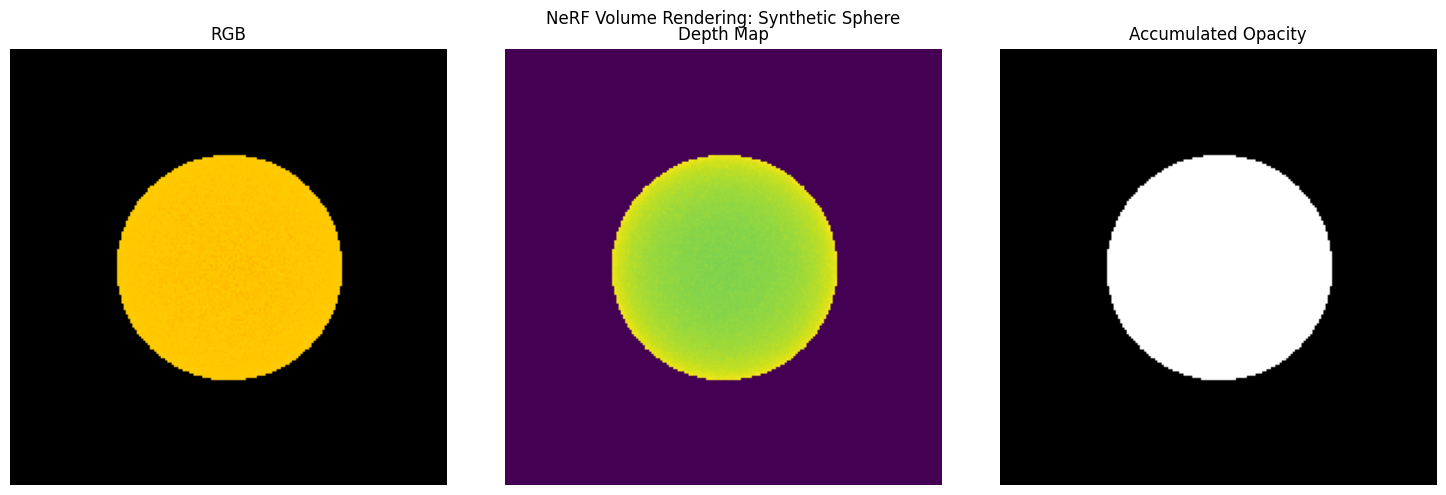

In [63]:
H, W = 200, 200
focal = 200.0
K = torch.tensor([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]], dtype=torch.float32, device=device)
c2w = torch.eye(4, device=device)
c2w[2, 3] = 2.0
near, far, N_samples = 1.0, 3.0, 64

print("Rendering synthetic sphere...")
with torch.no_grad():
    sphere_rgb, sphere_depth, sphere_acc = render_synthetic_image(H, W, K, c2w, near, far, N_samples)

print(f"RGB: {sphere_rgb.shape}, Depth: {sphere_depth.shape}, Acc: {sphere_acc.shape}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sphere_rgb.cpu().numpy())
axes[0].set_title("RGB")
axes[1].imshow(sphere_depth.cpu().numpy(), cmap='viridis')
axes[1].set_title("Depth Map")
axes[2].imshow(sphere_acc.cpu().numpy(), cmap='gray')
axes[2].set_title("Accumulated Opacity")
for ax in axes: ax.axis('off')
plt.suptitle("NeRF Volume Rendering: Synthetic Sphere")
plt.tight_layout()
plt.show()

---
## Test 2: NeRF MLP Forward Pass (Untrained)

Rendering with untrained NeRF MLP...
RGB: torch.Size([200, 200, 3]), Depth: torch.Size([200, 200])
RGB range: [0.4805, 0.4934]


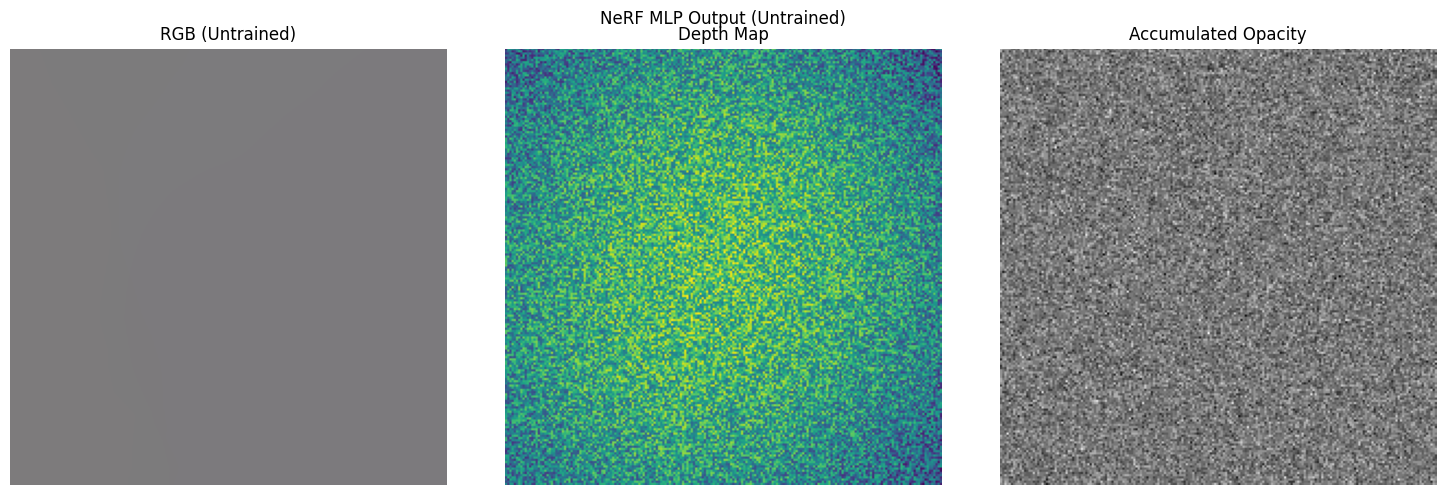

In [64]:
model = NeRF().to(device)

print("Rendering with untrained NeRF MLP...")
with torch.no_grad():
    mlp_rgb, mlp_depth, mlp_acc = render_image(H, W, K, c2w, model, near, far, N_samples)

print(f"RGB: {mlp_rgb.shape}, Depth: {mlp_depth.shape}")
print(f"RGB range: [{mlp_rgb.min():.4f}, {mlp_rgb.max():.4f}]")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mlp_rgb.cpu().numpy())
axes[0].set_title("RGB (Untrained)")
axes[1].imshow(mlp_depth.cpu().numpy(), cmap='viridis')
axes[1].set_title("Depth Map")
axes[2].imshow(mlp_acc.cpu().numpy(), cmap='gray')
axes[2].set_title("Accumulated Opacity")
for ax in axes: ax.axis('off')
plt.suptitle("NeRF MLP Output (Untrained)")
plt.tight_layout()
plt.show()